# Genetic/Linguistic linkage

## Part 1: Making the linker

Here we read the language data (`OCSEAN_language_collection_overview_June_25.xlsx` as updated by us, and `OCSEAN_initial_englishsheet.xlsx` as generated in Step 01) and link the languages to the GENETIC data given in `sample_list_161120.xlsx`.

The result is a `linguistic_genetic_linker2.xlsx` which looks like this:

```
         	GeneticPopulationName 	LinguisticName 	GeneticPopulationCluster
AgtaBulusan 	AgtaBulusan 	        Agta 	          P_Bik
Bicolano 	  Bicolano 	        Bicolano 	    P_Bik
```

with 56 Matches,  56 Genetic Named populations,  33 Genetic Clusters,  54 Language populations.

In [173]:
import pandas as pd # Pandas is the most common "data frame", i.e. Excel-sheet reader
import os # os = operating system; we use this for accessing files on the computer
import re
import numpy as np
from thefuzz import process

In [183]:
englishsheet=pd.read_excel(os.path.join("Pipeline results","OCSEAN_initial_englishsheet.xlsx"),na_filter=False,index_col=0)  
englishsheet.tail(2) # Look at the top few values


,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,Mismatches_IndoOrTaga,Original_FileName,QC_FileName,Google Map Coordinate,latitude,longitude,Has_QC_File,File_Source,Has_IPA,Has_English,Language_AsInFile
Language_BasedOnMasterSheet,,,,,,,,,,,,,,,,,,,
Waray,WAR,the Phillipines,1178,Yes,Not yet,"English Tagalog available, no Indonesian. No s...",space? Didn’t separate,0,1,OCSEAN-WAR_20240407-WORDLIST_1TO1228.xlsx,OCSEAN-WAR_20240407-WORDLIST_1TO1228_PostQC.xlsx,"12.312908225545875, 125.01703265863979",12.312908,125.017033,True,CleanedFiles-v1.1,False,True,Waray
Yakan,YKA,the Phillipines,1129,Yes,Not Yet,"Lowered cases, Indonesian available. English/I...",", (and space?)",0,0,OCSEAN-YKA_20240324-WORDLIST_1TO1228.xlsx,OCSEAN-YKA_20240324-WORDLIST_1TO1228_PostQC.xlsx,"6.898960, 122.087217",6.89896,122.087217,True,CleanedFiles-v1.1,False,True,Yakan


In [184]:
linguisticsheet=pd.read_excel(os.path.join("Metadata","OCSEAN_language_collection_overview_June_25.xlsx"),na_filter=False,index_col=0)
linguisticsheet.head(2)

,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,Mismatches_IndoOrTaga,Original_FileName,QC_FileName,Google Map Coordinate
Language_BasedOnMasterSheet,,,,,,,,,,,,
Abui Bunggeta,ABZ,Indonesia,604,Yes,Yes,Some English and or Indonesian words in this l...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST.xlsx,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST_PostQC.xlsx,
Abui Kilakawada,ABZ,Indonesia,604,Yes,Yes,English and English Elicitation notes complete...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST.xlsx,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST_PostQC...,


In [185]:
linguisticsheet=pd.merge(linguisticsheet,englishsheet[['Language_AsInFile']],
         left_index=True,right_index=True,how='left')
linguisticsheet['Language'] = linguisticsheet['Language_AsInFile'].fillna(pd.Series(linguisticsheet.index, index=linguisticsheet.index))
linguisticsheet.tail(2) # Look at the top few values
isea_linguistics=list(linguisticsheet['Language'].unique())

In [186]:
geneticsheet_pn=pd.read_excel(os.path.join("genetic","sample_list_161120.xlsx"),sheet_name="FS pop name codes",header=None)
print(geneticsheet_pn.shape)
geneticsheet_pn.columns = [
    'genetic_label',    # Column 0
    'continent',        # Column 1
    'group',        # Column 2
    'finest_label',     # Column 3
    'label_code',    # Column 4
    'group_id',      # Column 5
    'gt_label'    # Column 6
]
geneticsheet_pn['finest_label']=geneticsheet_pn['finest_label'].fillna(geneticsheet_pn['group'])
geneticsheet_pn.tail()


(179, 7)


,genetic_label,continent,group,finest_label,label_code,group_id,gt_label
174,WIND_Nias,WIND,Nias,Nias,WI_Nias,7,WI_Nias
175,WIND_Sulaw_Bugis,WIND,Sulaw,Bugis,WI_SulBugis,11,WI_SulBu
176,WIND_Sulaw_Kajang,WIND,Sulaw,Kajang,WI_SulKajang,12,WI_SulKa
177,WIND_Sulaw_Mandar,WIND,Sulaw,Mandar,WI_SulMandar,12,WI_SulMa
178,WIND_Sumatra,WIND,Sumatra,Sumatra,WI_Sum,6,WI_Sum


In [187]:
geneticsheet_pn['best_id'] = geneticsheet_pn['finest_label'].fillna(geneticsheet_pn['group'])
#geneticsheet_pn['best_id']
geneticsheet_pn.tail(10)
#print(geneticsheet_pn[['2', '3', 'new_col']].tail())

,genetic_label,continent,group,finest_label,label_code,group_id,gt_label,best_id
169,WIND_Born_Banjar,WIND,Born,Banjar,WI_BrBan,8,WI_BrBan,Banjar
170,WIND_Born_Samihim,WIND,Born,Samihim,WI_BrSamihim,12,WI_BrSam,Samihim
171,WIND_Born_Warukin,WIND,Born,Warukin,WI_BrWarukin,12,WI_BrWar,Warukin
172,WIND_Java,WIND,Java,Java,WI_Java,7,WI_Java,Java
173,WIND_Mentawai,WIND,Mentawai,Mentawai,WI_Ment,7,WI_Ment,Mentawai
174,WIND_Nias,WIND,Nias,Nias,WI_Nias,7,WI_Nias,Nias
175,WIND_Sulaw_Bugis,WIND,Sulaw,Bugis,WI_SulBugis,11,WI_SulBu,Bugis
176,WIND_Sulaw_Kajang,WIND,Sulaw,Kajang,WI_SulKajang,12,WI_SulKa,Kajang
177,WIND_Sulaw_Mandar,WIND,Sulaw,Mandar,WI_SulMandar,12,WI_SulMa,Mandar
178,WIND_Sumatra,WIND,Sumatra,Sumatra,WI_Sum,6,WI_Sum,Sumatra


In [188]:
isea_genetics=geneticsheet_pn['best_id'][geneticsheet_pn['continent'].isin(['PH','WIND'])]
isea_genetics=list(isea_genetics.unique())
isea_genetics_df=geneticsheet_pn[geneticsheet_pn['best_id'].isin(isea_genetics)]
isea_genetics_df

,genetic_label,continent,group,finest_label,label_code,group_id,gt_label,best_id
31,PH_Bas_Ibatan,PH,Bas,Ibatan,P_Bas,5,P_Bas,Ibatan
32,PH_Bas_Itbayaten,PH,Bas,Itbayaten,P_Bas,5,P_Bas,Itbayaten
33,PH_Bas_Ivatan,PH,Bas,Ivatan,P_Bas,5,P_Bas,Ivatan
34,PH_Bik_AgtaBulusan,PH,Bik,AgtaBulusan,P_Bik,5,P_Bik,AgtaBulusan
35,PH_Bik_AgtaMatnog,PH,Bik,AgtaMatnog,P_Bik,5,P_Bik,AgtaMatnog
...,...,...,...,...,...,...,...,...
174,WIND_Nias,WIND,Nias,Nias,WI_Nias,7,WI_Nias,Nias
175,WIND_Sulaw_Bugis,WIND,Sulaw,Bugis,WI_SulBugis,11,WI_SulBu,Bugis
176,WIND_Sulaw_Kajang,WIND,Sulaw,Kajang,WI_SulKajang,12,WI_SulKa,Kajang
177,WIND_Sulaw_Mandar,WIND,Sulaw,Mandar,WI_SulMandar,12,WI_SulMa,Mandar


In [189]:
genetic_mapping=isea_genetics_df.copy()
genetic_mapping['LinguisticName']= ''
genetic_mapping['ScoreLinguistics']= 0
genetic_mapping.index=genetic_mapping['best_id']
for pop in isea_genetics:
    match, score = process.extractOne(pop, isea_linguistics)
    matchesmore = process.extract(pop, isea_linguistics, limit=5)
    genetic_mapping.loc[pop,'LinguisticName']=match
    genetic_mapping.loc[pop,'LinguisticAlts']=",".join([x[0] for x in matchesmore])
    genetic_mapping.loc[pop,'ScoreLinguistics']=score
genetic_mapping=genetic_mapping.sort_values('ScoreLinguistics')
genetic_mapping.to_excel(os.path.join("data-processed","genetic_mapping.xlsx"))
genetic_mapping.head()

,genetic_label,continent,group,finest_label,label_code,group_id,gt_label,best_id,LinguisticName,ScoreLinguistics,LinguisticAlts
best_id,,,,,,,,,,,
Yogad,PH_Cag_Yogad,PH,Cag,Yogad,P_Cag,5,P_Cag,Yogad,Bali_Aga,51,"Bali_Aga,Dumagat San Luis Aurora,Gaddang,Abui_..."
Teduray,PH_BilWM_Teduray,PH,BilWM,Teduray,P_BilWM,7,P_BilWM,Teduray,Termanu,57,"Termanu,Manubo_Tasaday,Arta,Reta,Tagbanwa Tand..."
Warukin,WIND_Born_Warukin,WIND,Born,Warukin,WI_BrWarukin,12,WI_BrWar,Warukin,Alurung,57,"Alurung,Alorung/Alorese Alor Kecil,Wersing Pan..."
Bugkalot,PH_CorSo_Bugkalot,PH,CorSo,Bugkalot,P_CorSo,7,P_CorSo,Bugkalot,Tagakaulo,59,"Tagakaulo,Kamang Bukapiting,Alorung/Alorese Al..."
OvuManuvo,PH_MboSEM_OvuManuvo,PH,MboSEM,OvuManuvo,P_MboSEM,8,P_MboSEM,OvuManuvo,Manubo_Tasaday,60,"Manubo_Tasaday,Umajamnon,Manea,Mauta,Savu"


## Read the manually edited version of the genetic mapping

This makes the `linguistic_genetic_linker2.xlsx` file, and is used to check that there is no inconsistencies between genetic and linguistic populations.

In [195]:
genetic_mapping_checked=pd.read_excel(os.path.join("data-manual","genetic_mapping_v1.xlsx"),index_col=0)
genetic_mapping_checked['finest_label']=genetic_mapping_checked['finest_label'].fillna(genetic_mapping_checked['group'])
genetic_mapping_checked

,genetic_label,continent,group,finest_label,label_code,group_id,gt_label,best_id,LinguisticName,ScoreLinguistics,LinguisticAlts,manual_cluster,Phenotype
Yogad,PH_Cag_Yogad,PH,Cag,Yogad,P_Cag,5,P_Cag,Yogad,NaN,51,"Bali_Aga,Dumagat San Luis Aurora,Gaddang,Abui ...",NaN,NaN
Warukin,WIND_Born_Warukin,WIND,Born,Warukin,WI_BrWarukin,12,WI_BrWar,Warukin,NaN,57,"Alurung,Alorung/Alorese Alor Kecil,Wersing Pan...",NaN,NaN
Teduray,PH_BilWM_Teduray,PH,BilWM,Teduray,P_BilWM,7,P_BilWM,Teduray,NaN,57,"Termanu,Manubo_Tasaday,Arta,Reta Ternate,Tagba...",NaN,NaN
Bugis,WIND_Sulaw_Bugis,WIND,Sulaw,Bugis,WI_SulBugis,11,WI_SulBu,Bugis,NaN,60,"Abui_Bunggeta,Abui Kilakawada,Abui_Mobyetang,A...",NaN,NaN
BajoD,WIND_Born_BajoD,WIND,Born,BajoD,WI_BrBaj,8,WI_BrBaj,BajoD,NaN,60,"Bagobo Tagabawa,Ibaloi_Ibaloy,Inabaknon,Agusan...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sambal,PH_Cen_Sambal,PH,Cen,Sambal,P_Cen,5,P_Cen,Sambal,Sambal,100,"Sambal,Sumba Wejewa,Sumba, Anakalang,Sumba, Lo...",4.0,NaN
Boholano,PH_VisEV_Boholano,PH,VisEV,Boholano,P_VisEV,7,P_VisEV,Boholano,Boholano,100,"Boholano,Bicolano,Obo,Bolinao,Balangao",0.0,NaN
Cebuano,PH_VisEV_Cebuano,PH,VisEV,Cebuano,P_VisEV,7,P_VisEV,Cebuano,Cebuano,100,"Cebuano,Butuanon,Chabacano_Caviteno,Akeanon,Cu...",0.0,NaN
Yakan,PH_SamDY_Yakan,PH,SamDY,Yakan,P_SamDY,7,P_SamDY,Yakan,Yakan,100,"Yakan,Ivatan_Ichbayatan,Kankana_ey,Akeanon,Ama...",2.0,NaN


In [197]:
genetic_mapping_checked=genetic_mapping_checked.dropna(subset=['LinguisticName'])
linker = genetic_mapping_checked[['best_id','LinguisticName','gt_label']].copy()
linker=linker.rename(columns={'best_id': 'GeneticPopulationName','gt_label': 'GeneticPopulationCluster'})
linker.to_excel(os.path.join('Metadata','linguistic_genetic_linker2.xlsx'))
#gt_label
print(linker.shape[0],"Matches, ",
      linker.loc[:,'GeneticPopulationName'].nunique(),"Genetic Named populations, ",
      linker.loc[:,'GeneticPopulationCluster'].nunique(),"Genetic Clusters, ",
      linker.loc[:,'LinguisticName'].nunique(),"Language populations")

56 Matches,  56 Genetic Named populations,  33 Genetic Clusters,  54 Language populations


In [198]:
multi_cluster_langs = (
    linker.groupby('LinguisticName')['GeneticPopulationCluster']
    .nunique()
    .loc[lambda x: x > 1]
)
print("LinguisticNames with multiple Genetic Clusters:")
print(multi_cluster_langs)

LinguisticNames with multiple Genetic Clusters:
Series([], Name: GeneticPopulationCluster, dtype: int64)


In [199]:
# Filter rows with LinguisticNames in multiple clusters
linker[linker['LinguisticName'].isin(multi_cluster_langs.index)].sort_values('LinguisticName')

,GeneticPopulationName,LinguisticName,GeneticPopulationCluster


In [200]:
multi_lang_clusters = (
    linker.groupby('GeneticPopulationCluster')['LinguisticName']
    .nunique()
    .loc[lambda x: x > 1]
)
print("Genetic Clusters with multiple LinguisticNames:")
print(multi_lang_clusters)

Genetic Clusters with multiple LinguisticNames:
GeneticPopulationCluster
P_Bik       2
P_BilSM     3
P_Cag       2
P_Cen       3
P_CorCen    5
P_Dan       2
P_MboCM     3
P_MynSo     2
P_Pal       3
P_SamDY     2
P_VisEV     3
P_VisWV     3
Name: LinguisticName, dtype: int64


In [201]:
# Filter rows with Genetic Clusters linked to multiple LinguisticNames
linker[linker['GeneticPopulationCluster'].isin(multi_lang_clusters.index)].sort_values('GeneticPopulationCluster')

,GeneticPopulationName,LinguisticName,GeneticPopulationCluster
AgtaBulusan,AgtaBulusan,Agta,P_Bik
Bicolano,Bicolano,Bicolano,P_Bik
Tboli,Tboli,Tboli,P_BilSM
BlaanSarangani,BlaanSarangani,Blaan Sarangani,P_BilSM
Obo,Obo,Obo,P_BilSM
Gaddang,Gaddang,Gaddang,P_Cag
Ibanag,Ibanag,Ibanag,P_Cag
Bolinao,Bolinao,Bolinao,P_Cen
Kapampangan,Kapampangan,Kapampangan,P_Cen
Sambal,Sambal,Sambal,P_Cen


## Part 2: Genetic Clustering

Here we construct the genetic clusterings for popluations that link to the data.

The input is the `sample_list_161120.xlsx` file describing the genetics, the chromosome painting results `isea1763_linked.chunklengths.out.gz` and the linker from above.



In [202]:
## Only used for checking
geneticsheet_pn=pd.read_excel(os.path.join("genetic","sample_list_161120.xlsx"),sheet_name="FS pop name codes",header=None)
geneticsheet_pn.columns = [
    'genetic_label',    # Column 0
    'continent',        # Column 1
    'group',        # Column 2
    'finest_label',     # Column 3
    'label_code',    # Column 4
    'group_id',      # Column 5
    'gt_label'    # Column 6
]
geneticsheet_pn.index=geneticsheet_pn['gt_label']
geneticsheet_pn

,genetic_label,continent,group,finest_label,label_code,group_id,gt_label
gt_label,,,,,,,
EA_CDX,EAS_CDX,EAS,CDX,NaN,EA_CDX,6,EA_CDX
EA_CHB,EAS_CHB,EAS,CHB,NaN,EA_CHB,6,EA_CHB
EA_CHS,EAS_CHS,EAS,CHS,NaN,EA_CHS,6,EA_CHS
EA_KHV,EAS_KHV,EAS,KHV,NaN,EA_KHV,6,EA_KHV
EI_Alor,EIND_Alor,EIND,Alor,NaN,EI_Alor,7,EI_Alor
...,...,...,...,...,...,...,...
WI_Nias,WIND_Nias,WIND,Nias,NaN,WI_Nias,7,WI_Nias
WI_SulBu,WIND_Sulaw_Bugis,WIND,Sulaw,Bugis,WI_SulBugis,11,WI_SulBu
WI_SulKa,WIND_Sulaw_Kajang,WIND,Sulaw,Kajang,WI_SulKajang,12,WI_SulKa


In [203]:
linker=pd.read_excel(os.path.join("Metadata","linguistic_genetic_linker2.xlsx"),index_col=0)

In [204]:
genetic_cp=pd.read_table(os.path.join("genetic","isea1763_linked.chunklengths.out.gz"),sep=' ',index_col=0)
genetic_cp.head()

,EA_CDX61,EA_CDX62,EA_CDX63,EA_CDX64,EA_CDX65,EA_CDX66,EA_CDX67,EA_CDX68,EA_CDX69,EA_CDX70,...,WI_Sum2257,WI_Sum2258,WI_Sum2259,WI_Sum2260,WI_Sum2261,WI_Sum2262,WI_Sum2263,WI_Sum2264,WI_Sum2265,WI_Sum2266
Recipient,,,,,,,,,,,,,,,,,,,,,
EA_CDX61,0.000000,33.822812,33.494802,30.282353,20.741461,46.611786,71.464214,28.471252,34.062036,31.276448,...,4.476265,4.952288,5.730214,6.096489,6.688157,5.111700,4.657796,4.886352,5.817896,3.969590
EA_CDX62,32.187358,0.000000,26.591131,25.254914,27.324793,39.661127,22.261141,28.543376,39.484963,29.432066,...,5.150792,4.958824,5.268282,4.261503,7.336589,5.121259,6.862042,3.309268,4.930612,5.141992
EA_CDX63,34.733189,21.696241,0.000000,72.931626,32.989223,34.688795,56.305969,30.673844,23.253046,38.198480,...,4.980224,5.701539,6.440699,7.335597,5.162490,3.820426,4.946434,3.559722,4.199481,3.753347
EA_CDX64,31.148436,25.582899,75.555385,0.000000,53.461749,26.372113,21.701698,32.360519,32.682013,27.204838,...,5.862414,6.068530,7.388267,6.032632,4.813438,3.957060,5.365919,6.659964,3.690494,4.065255
EA_CDX65,26.859875,29.992559,34.075423,56.205245,0.000000,29.214585,22.215710,18.425334,26.164596,18.146304,...,6.032446,5.352609,6.951948,6.224027,6.114806,3.733947,8.235606,5.224871,5.994234,4.967952


In [205]:
ind_pop_names = [re.sub(r"[0-9]+", '', x) for x in genetic_cp.index]
pop_ref=list(set(geneticsheet_pn['gt_label']))
ind_in_pop=[x in pop_ref for x in ind_pop_names]


In [206]:
## Check whether all individuals are in the data
from collections import Counter
c = Counter( ind_in_pop )

print( c.items() )

dict_items([(True, 1763)])


And how many of the names are in the linker so we have matched language data?

In [207]:
pop_ref_linker=list(set(linker['GeneticPopulationCluster']))
ind_in_linker=[x in pop_ref_linker for x in ind_pop_names]

In [208]:
from collections import Counter
c = Counter( ind_in_linker )
print( c.items() )

dict_items([(False, 926), (True, 837)])


In [210]:
genetic_matched_cp=genetic_cp.iloc[ind_in_linker,ind_in_linker].copy()
genetic_matched_cp.shape
## This is how many individuals we will keep:

(837, 837)

## Population list

In [364]:
poplist=dict()
for pop in pop_ref_linker:
    poplist[pop] = genetic_cp.index[[x==pop for x in ind_pop_names]]
print(len(poplist))
print(poplist.keys())

33
dict_keys(['P_Cen', 'P_MynNo', 'P_Klm', 'P_Cag', 'P_VisWV', 'P_MboSEM', 'WI_Ment', 'P_MnsWD', 'P_San', 'P_NegMin', 'P_VisEV', 'P_VisWM', 'P_MboCM', 'P_Ilo', 'P_Bik', 'P_CorSo', 'P_CorNo', 'P_Cre', 'P_MboSM', 'P_Dan', 'P_Sub', 'P_NegVis', 'P_SamDY', 'P_MnsED', 'P_MynSo', 'WI_Bali', 'P_Pal', 'P_VisNM', 'P_BilSM', 'P_Bas', 'P_NegPal', 'P_NegNEL', 'P_CorCen'])


In [212]:
# Create an empty DataFrame to hold the results
pops = list(poplist.keys())
cluster_matrix = pd.DataFrame(index=pops, columns=pops, dtype=float)

for pop1 in pops:
    inds1 = poplist[pop1]
    for pop2 in pops:
        inds2 = poplist[pop2]
        
        submatrix = genetic_matched_cp.loc[inds1, inds2]

        if pop1 == pop2:
            # Exclude self comparisons (diagonal elements)
            mask = ~ np.eye(len(inds1), dtype=bool)
            values = submatrix.values[mask]
        else:
            values = submatrix.values.flatten()

        # Remove nan if any (e.g., if some individuals aren't in cp)
        values = values[~np.isnan(values)]
        
        if len(values) > 0:
            cluster_matrix.loc[pop1, pop2] = values.mean()
        else:
            cluster_matrix.loc[pop1, pop2] = np.nan  # Or 0 if preferred

In [219]:
# Step 1: Balance the matrix
genetic_similarity = cluster_matrix 
genetic_similarity_symm = (genetic_similarity + genetic_similarity.T) / 2
genetic_similarity_symm.to_excel(os.path.join("Pipeline results","genetic_similarity.xlsx"))
genetic_similarity_symm.iloc[0:6,0:6]

,P_Cen,P_MynNo,P_Klm,P_Cag,P_VisWV,P_MboSEM
P_Cen,24.810117,3.297982,3.486524,6.450448,4.476620,2.314625
P_MynNo,3.297982,463.436517,4.352975,2.221746,2.993348,1.153860
P_Klm,3.486524,4.352975,153.564514,2.736541,21.408243,1.703315
P_Cag,6.450448,2.221746,2.736541,32.191372,3.417137,1.901432
P_VisWV,4.476620,2.993348,21.408243,3.417137,39.252245,2.351788
P_MboSEM,2.314625,1.153860,1.703315,1.901432,2.351788,55.343592


## Part 3: Matched data

Here we take the raw results from the genetics and the raw results from the linguistics and force a match between them using the linker.

The result are matched files with identical row/columns.

We have TWO definitions of linguistic similarity: counts of cognates, or distance-based measures. We will calculate both, but distance-based is more justifiable.

In [220]:
linker=pd.read_excel(os.path.join("Metadata","linguistic_genetic_linker2.xlsx"),index_col=0)
print(linker.head())
lang_to_gene = linker.set_index('LinguisticName')['GeneticPopulationCluster']
print(linker.shape)
len(list(linker['LinguisticName'].unique()))

                  GeneticPopulationName      LinguisticName  \
Agutaya                         Agutaya           Agutaynen   
Chavacano                     Chavacano  Chabacano_Caviteno   
BukidnonUmayamnon     BukidnonUmayamnon           Umajamnon   
SamaBangingi               SamaBangingi   Sinama_Banguingui   
Subanon                         Subanon             Subanen   

                  GeneticPopulationCluster  
Agutaya                              P_Klm  
Chavacano                            P_Cre  
BukidnonUmayamnon                  P_MboCM  
SamaBangingi                       P_SamDY  
Subanon                              P_Sub  
(56, 3)


54

In [367]:
gene_sim_raw=pd.read_excel(os.path.join("Pipeline results","genetic_similarity.xlsx"),index_col=0)
gene_sim_raw.iloc[0:5,0:10]

,P_Cen,P_MynNo,P_Klm,P_Cag,P_VisWV,P_MboSEM,WI_Ment,P_MnsWD,P_San,P_NegMin
P_Cen,24.810117,3.297982,3.486524,6.450448,4.476620,2.314625,2.069885,2.694320,3.241766,2.109284
P_MynNo,3.297982,463.436517,4.352975,2.221746,2.993348,1.153860,0.969756,1.357085,1.811875,1.297240
P_Klm,3.486524,4.352975,153.564514,2.736541,21.408243,1.703315,1.373040,1.960119,2.497783,2.022999
P_Cag,6.450448,2.221746,2.736541,32.191372,3.417137,1.901432,1.710316,2.298957,2.878990,1.703881
P_VisWV,4.476620,2.993348,21.408243,3.417137,39.252245,2.351788,1.723394,2.673453,3.374277,2.261269


In [222]:
# Step 1: Get valid language names from linker
valid_gen = linker['GeneticPopulationCluster'].unique()

# Step 2: Subset ling_sim (rows and columns)
genetics_cleaned = gene_sim_raw.loc[
    gene_sim_raw.index.intersection(valid_gen),  # rows
    gene_sim_raw.columns.intersection(valid_gen)  # columns
]
print("Before", gene_sim_raw.shape,", After",genetics_cleaned.shape)

Before (33, 33) , After (33, 33)


In [368]:
ling_distances_raw = pd.read_csv(os.path.join('Pipeline results','OCSEAN_processed_distance_matrix.csv'),index_col=0)
print(ling_distances_raw.shape)
ling_distances_raw.index

(78, 78)


Index(['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman',
       'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung',
       'Arta', 'Ata', 'Ati', 'Ba_a', 'Balangao', 'Bali_Aga', 'Balinese',
       'Batak', 'Bicolano', 'Boholano', 'Bolinao', 'Bontoc', 'Buhid', 'Bulus',
       'Chabacano_Caviteno', 'Cuyunon', 'Dela', 'Enggano', 'Gaddang',
       'Hanunuo', 'Hattang_Kaye', 'Hiligaynon', 'Hiligaynon_20240802',
       'Ibaloi_Ibaloy', 'Ilognon', 'Ilokano', 'Inabaknon', 'Ivatan_Ichbayatan',
       'Ivatan_Isabtangen', 'Kalinga', 'Kamayo', 'Kankana_ey', 'Kapampangan',
       'Kelon', 'Kinaray_a', 'Kolibogon', 'Kupang_Malay', 'Kusa',
       'Loloan_Malay', 'Manea', 'Manubo_Tasaday', 'Mauta', 'Mawes_Wares',
       'Mawesdai', 'Meranaw', 'Minamanwa', 'Molbog', 'Obo', 'Palawano',
       'Pangasinan', 'Reta', 'Sabu_Raijua', 'Sabu_Seba', 'Sangil',
       'Sinama_Banguingui', 'Sinama_Sitangkai', 'Sinama_Tabawan',
       'Sinurigaonon', 'Tagakaulo', 'Tagbanwa_Centra

In [236]:
ling_sim_raw = pd.read_csv(os.path.join('Pipeline results','OCSEAN_scaled_cognate_adjacency_matrix.csv'),index_col=0)
print(ling_sim_raw.shape)
ling_sim_raw.iloc[0:5,0:5]

(78, 78)


,Abui_Bunggeta,Abui_Kilakawada,Abui_Mobyetang,Abui_Pelman,Adang
Abui_Bunggeta,1.000000,0.690417,0.634996,0.612819,0.098258
Abui_Kilakawada,0.690417,1.000000,0.641047,0.610402,0.106526
Abui_Mobyetang,0.634996,0.641047,1.000000,0.763627,0.106613
Abui_Pelman,0.612819,0.610402,0.763627,1.000000,0.105837
Adang,0.098258,0.106526,0.106613,0.105837,1.000000


In [237]:
# Step 1: Get valid language names from linker
valid_langs = linker['LinguisticName'].unique()

# Step 2: Subset ling_sim (rows and columns)
ling_dist = ling_distances_raw.loc[
    ling_distances_raw.index.intersection(valid_langs),  # rows
    ling_distances_raw.columns.intersection(valid_langs)  # columns
]
ling_sim = ling_sim_raw.loc[
    ling_sim_raw.index.intersection(valid_langs),  # rows
    ling_sim_raw.columns.intersection(valid_langs)  # columns
]

print("Before", ling_distances_raw.shape," languages; After",ling_dist.shape,ling_sim.shape)

Before (78, 78)  languages; After (43, 43) (43, 43)


In [239]:
linker_filtered = linker[linker['LinguisticName'].isin(ling_sim.index)]

In [320]:
def fill_diagonal_with_next_highest(df):
    # Make a copy to avoid modifying in place
    filled_df = df.copy()

    # Convert to numpy array for efficiency
    arr = filled_df.values

    # For each row, get the second-largest value (excluding the diagonal)
    for i in range(len(arr)):
        # Mask the diagonal element to avoid using it
        row = np.delete(arr[i], i)
        arr[i, i] = np.nanmax(row)

    # If you want to put the result back into a DataFrame:
    filled_df = pd.DataFrame(arr, index=df.index, columns=df.columns)
    return filled_df

In [241]:
def match_by_duplication(genes,languages,linker):
    # Set up a Series mapping language → gene
    lang_to_gene = linker.set_index('LinguisticName')['GeneticPopulationCluster']

    # Get list of languages in desired output order
    languages = languages.index.tolist()

    # Use broadcasting to build new matrix by mapping via genes
    expanded_array = genes.loc[
        lang_to_gene.loc[languages],  # Rows: gene for each language
        lang_to_gene.loc[languages]   # Columns: gene for each language
    ].values

    # Wrap it back into a DataFrame
    expanded_genes = pd.DataFrame(expanded_array, index=languages, columns=languages)
    return(expanded_genes)

In [242]:
def rowcol_standarize(df):
    # Compute row means
    row_means = df.mean(axis=1)

    # Compute column means
    col_means = df.mean(axis=0)
    
    # Outer product of row and column means, then sqrt
    scaling_matrix = np.sqrt(np.outer(row_means, col_means))

    # Divide element-wise
    standardized = df / scaling_matrix
    
    # Keep original index and columns
    standardized = pd.DataFrame(standardized, index=df.index, columns=df.columns)
    return(standardized)

In [308]:
ling_matched.shape

(43, 43)

In [307]:
genetics_matched = match_by_duplication(gene_sim_raw,ling_sim,linker_filtered)
genetics_matched = rowcol_standarize(fill_diagonal_with_next_highest(genetics_matched))
ling_cognate_matched = rowcol_standarize(fill_diagonal_with_next_highest(ling_sim))
ling_matched = rowcol_standarize(fill_diagonal_with_next_highest(1-ling_dist))
print(ling_matched.iloc[0:5,0:5])
print(ling_cognate_matched.iloc[0:5,0:5])
print(genetics_matched.iloc[0:5,0:5])

               Agta  Agutaynen      Arta       Ata       Ati
Agta       1.385157   1.014636  1.523644  0.900072  0.830264
Agutaynen  1.014636   1.852796  0.818716  0.947172  1.108811
Arta       1.523644   0.818716  1.788966  0.706974  0.656045
Ata        0.900072   0.947172  0.706974  1.578480  1.018544
Ati        0.830264   1.108811  0.656045  1.018544  2.048648
               Agta  Agutaynen      Arta       Ata       Ati
Agta       1.442735   1.025341  1.510413  0.895323  0.772860
Agutaynen  1.025341   1.841410  0.802936  1.035397  1.002364
Arta       1.510413   0.802936  1.766649  0.697247  0.555002
Ata        0.895323   1.035397  0.697247  1.434830  0.863590
Ati        0.772860   1.002364  0.555002  0.863590  2.045513
               Agta  Agutaynen      Arta       Ata       Ati
Agta       7.089624   0.784452  0.704762  0.559568  0.890849
Agutaynen  0.784452   4.213665  0.649343  0.397442  1.773245
Arta       0.704762   0.649343  2.817449  0.349508  0.548826
Ata        0.559568   0.

In [251]:
print(genetics_matched.shape)
## This is how many populations we have after matching:

(43, 43)


In [252]:
allvalues=pd.DataFrame({'gene':genetics_matched.values.flatten(),
             'ling_similarity':ling_matched.values.flatten(),
             'ling_cognatefraction':ling_cognate_matched.values.flatten()
             })
correlation_matrix = allvalues.corr()
print(correlation_matrix)

                          gene  ling_similarity  ling_cognatefraction
gene                  1.000000         0.641919              0.622465
ling_similarity       0.641919         1.000000              0.973736
ling_cognatefraction  0.622465         0.973736              1.000000


In [253]:
genetics_matched.to_excel(os.path.join("Pipeline results","matched_genetic_similarity.xlsx"))
ling_cognate_matched.to_excel(os.path.join("Pipeline results","matched_linguistic_cognate_overlap.xlsx"))
ling_matched.to_excel(os.path.join("Pipeline results","matched_linguistic_similarity.xlsx"))

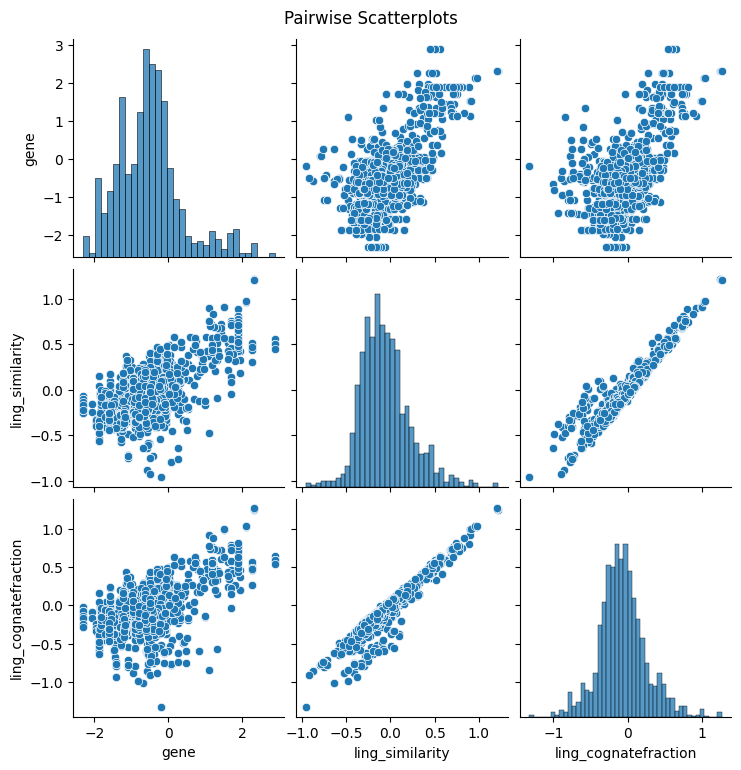

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(np.log(allvalues))
plt.suptitle("Pairwise Scatterplots", y=1.02)
plt.savefig(os.path.join("Pipeline results","similarity correlation"), dpi=100, bbox_inches='tight')
plt.show()

## Part 4: Structure by semantic fields

In [313]:
semantic_field_df=pd.read_excel("semantic_field_list.xlsx")
semantic_fields=semantic_field_df['Semantic_Field'].to_list()
semantic_fields

['The physical world',
 'Spatial relations',
 'Time',
 'Social and political relations',
 'Agriculture and vegetation',
 'Motion',
 'Basic actions and technology',
 'Warfare and hunting',
 'Food and drink',
 'Clothing and grooming',
 'The house',
 'Religion and belief',
 'The body',
 'Kinship',
 'Emotions and values',
 'Speech and language',
 'Cognition',
 'Miscellaneous function words',
 'Quantity',
 'Animals',
 'Sense perception',
 'Possession',
 'Law']

In [304]:
sf_dist_raw_base.shape

(43, 77)

In [321]:
sf_list={}
lang_list=[]
for semantic_field in semantic_fields:
    sf_dist_raw_base=ling_matched.copy()
    sf_dist_raw_base.loc[:,:]=np.nan
    sf_dist_raw = pd.read_csv(os.path.join('Pipeline results','Semantic',''.join(['semantic_field_',semantic_field]),
                                                  'OCSEAN_processed_distance_matrix.csv'),index_col=0)
    sf_dist = sf_dist_raw.loc[
        sf_dist_raw.index.intersection(valid_langs),  # rows
        sf_dist_raw.columns.intersection(valid_langs)  # columns
    ]
    sf_dist_raw_base.loc[sf_dist.index.to_list(),sf_dist.columns.to_list()]=sf_dist.values
    sf_dist = rowcol_standarize(fill_diagonal_with_next_highest(1-sf_dist_raw_base))
    sf_list[semantic_field]=sf_dist
    sf_dist.to_excel(os.path.join('Pipeline results','Semantic',''.join(['matched_linguistic_semantic_field_',semantic_field,'.xlsx'])))

/var/folders/sd/6b6ndf8s69l3glyl3t0xl7zr0000gq/T/ipykernel_75817/4206837314.py:12: RuntimeWarning: All-NaN slice encountered
  arr[i, i] = np.nanmax(row)
/var/folders/sd/6b6ndf8s69l3glyl3t0xl7zr0000gq/T/ipykernel_75817/4206837314.py:12: RuntimeWarning: All-NaN slice encountered
  arr[i, i] = np.nanmax(row)
/var/folders/sd/6b6ndf8s69l3glyl3t0xl7zr0000gq/T/ipykernel_75817/4206837314.py:12: RuntimeWarning: All-NaN slice encountered
  arr[i, i] = np.nanmax(row)
/var/folders/sd/6b6ndf8s69l3glyl3t0xl7zr0000gq/T/ipykernel_75817/4206837314.py:12: RuntimeWarning: All-NaN slice encountered
  arr[i, i] = np.nanmax(row)
/var/folders/sd/6b6ndf8s69l3glyl3t0xl7zr0000gq/T/ipykernel_75817/4206837314.py:12: RuntimeWarning: All-NaN slice encountered
  arr[i, i] = np.nanmax(row)
/var/folders/sd/6b6ndf8s69l3glyl3t0xl7zr0000gq/T/ipykernel_75817/4206837314.py:12: RuntimeWarning: All-NaN slice encountered
  arr[i, i] = np.nanmax(row)
/var/folders/sd/6b6ndf8s69l3glyl3t0xl7zr0000gq/T/ipykernel_75817/4206837314.

In [319]:
[x.shape for x in sf_list.values()]

[(43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43),
 (43, 43)]

## Appendix: some plotting

This is for visualisation of the genetic data. We'll get better visualisations of the merged datasets in later worksheets.

In [214]:
import numpy as np
import pandas as pd

def sinkhorn_balance(df, flatten=True, max_iter=1000, tol=1e-6):
    if flatten:
        df= fill_diagonal_with_next_highest(df)       
    mat = df.values.copy()
    mask = ~np.isnan(mat)
    
    # Replace NaNs with zero for now (or interpolate if you prefer)
    mat[~mask] = 0

    for _ in range(max_iter):
        # Normalize rows
        row_sums = mat.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        mat = mat / row_sums

        # Normalize columns
        col_sums = mat.sum(axis=0, keepdims=True)
        col_sums[col_sums == 0] = 1
        mat = mat / col_sums

        # Check convergence
        if np.allclose(mat.sum(axis=0), mat.sum(axis=1), atol=tol):
            break

    return pd.DataFrame(mat, index=df.index, columns=df.columns)

/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


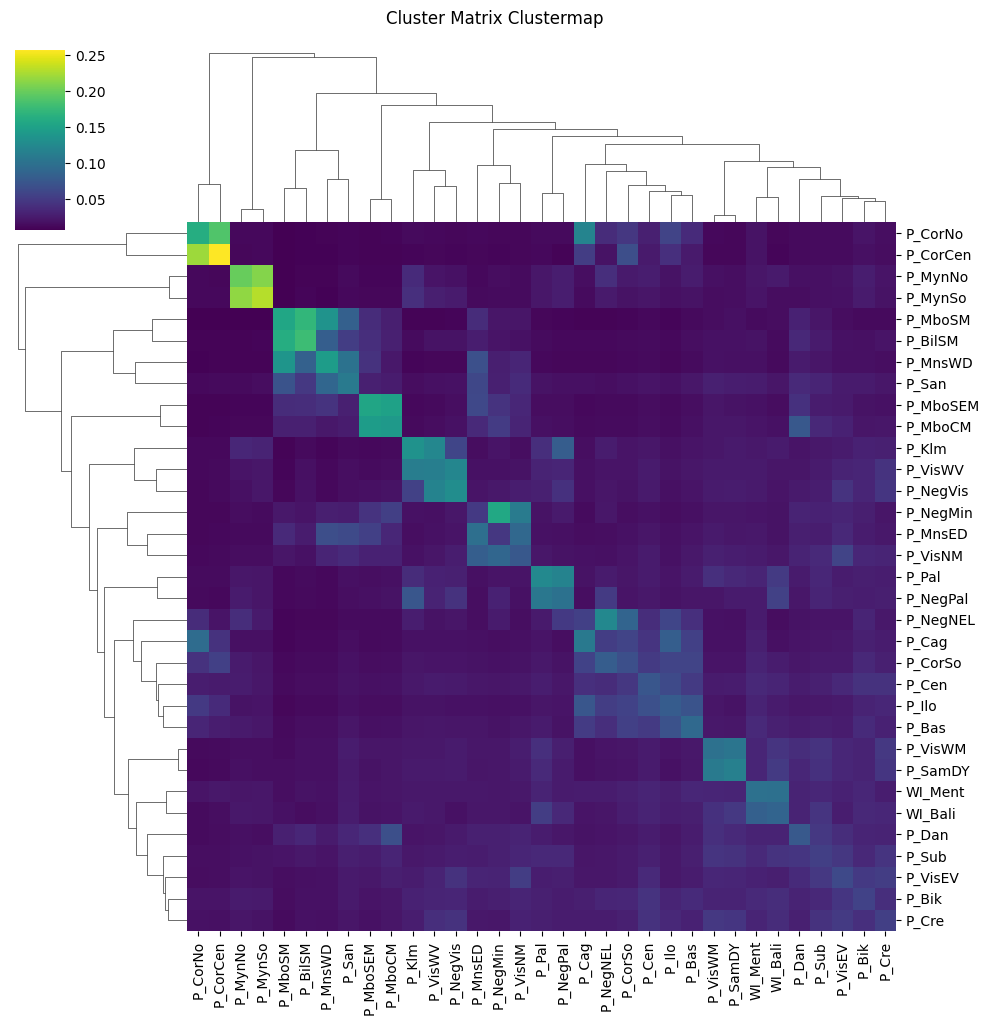

In [217]:
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

# Assuming your matrix is symmetric and clean (e.g. cluster_matrix)
balanced = genetic_similarity_symm

sns.clustermap(
    sinkhorn_balance(cluster_matrix),
    method='average',     # linkage method for clustering
    metric='euclidean',   # distance metric
    cmap='viridis',       # or 'coolwarm', 'mako', etc.
    figsize=(10, 10),
    
    square=True
)
plt.suptitle("Cluster Matrix Clustermap", y=1.02)
plt.show()

## Metadata linkage

In [346]:
ph_metadata=pd.read_excel(os.path.join("Metadata","Metadata_Philippine_EthnolinguisticGroups.xlsx"))
ph_metadata.head()

,Name,Language,Language Group,Province,Region (Long Name),Region (Short Name),Island Group,Coordinate 1,Coordinate 2,Cluster 1,Cluster 2,Cluster 3
0,AgtaBulusan,Southern Sorsogon,Visayan,Sorsogon,Bicol Region,Region 5,Luzon,12.76709,124.12231,Non-Negrito,Luzon Lowlander,Bicolano
1,AgtaCasiguran,Casiguran Agta,Northeastern Luzon,Quirino,Cagayan Valley Region,Region 2,Luzon,16.25873,121.89366,Negrito,Northern Philippine Negrito,Northeast Luzon Negrito
2,AgtaDumagat,Dumagat Agta,Central Luzon,Quezon,Calabarzon Region,Region 4A,Luzon,14.90678,121.49131,Negrito,Northern Philippine Negrito,Southern Luzon Negrito
3,AgtaDupaningan,Dupaningan Agta,Northeastern Luzon,Cagayan,Cagayan Valley Region,Region 2,Luzon,18.56042,122.14054,Negrito,Northern Philippine Negrito,Northeast Luzon Negrito
4,AgtaIraya,Mount Iraya Agta,Bikol,Camarines Sur,Bicol Region,Region 5,Luzon,13.47195,123.52675,Negrito,Northern Philippine Negrito,Southeast Luzon Negrito


In [335]:
pops_matching=pd.DataFrame({"Reference":genetics_matched.index})
pops_matching.index=pops_matching['Reference']
pops_matching_list=pops_matching['Reference'].tolist()

In [340]:
pops_matching['MetaDataName']= ''
pops_matching['Score']= 0
pops_matching['MetaDataAlts']= ''
for pop in pops_matching_list:
    match, score = process.extractOne(pop, ph_metadata['Name'].tolist())
    matchesmore = process.extract(pop, ph_metadata['Name'].tolist(), limit=5)
    pops_matching.loc[pop,'MetaDataName']=match
    pops_matching.loc[pop,'MetaDataAlts']=",".join([x[0] for x in matchesmore])
    pops_matching.loc[pop,'Score']=score
pops_matching=pops_matching.sort_values('Score')
pops_matching.to_excel(os.path.join("data-processed","metadata_mapping.xlsx"))


In [354]:
ph_metadata_linker=pd.read_excel(os.path.join("Metadata","metadata_linker.xlsx"))

metadata_merged=pd.merge(ph_metadata_linker[['Reference','MetaDataName']].copy(),
        ph_metadata,
         left_on="MetaDataName",
         right_on="Name",
         how='left')
metadata_merged.index=metadata_merged["Reference"]
metadata_merged.head()

,Reference,MetaDataName,Name,Language,Language Group,Province,Region (Long Name),Region (Short Name),Island Group,Coordinate 1,Coordinate 2,Cluster 1,Cluster 2,Cluster 3
Reference,,,,,,,,,,,,,,
Balinese,Balinese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Manubo_Tasaday,Manubo_Tasaday,ManoboAgusan,ManoboAgusan,ManoboAgusan,Manobo,Agusan del Sur,Caraga Region,Region 13,Mindanao,8.21646,126.04584,Non-Negrito,Manobo,Manobo Eastern
Agutaynen,Agutaynen,Agutaya,Agutaya,Agutaynen,Kalamian,Palawan,Mimaropa Region,Region 4B,Luzon,11.15305,120.96303,Non-Negrito,Palawan,Kalamian
Chabacano_Caviteno,Chabacano_Caviteno,Chavacano,Chavacano,Chavacano,Creole,Zamboaga del Sur,Zamboanga Peninsula Region,Region 9,Visayas,6.92144,122.07902,Non-Negrito,Northerm Mindanao,Chavacano
Sinama_Banguingui,Sinama_Banguingui,SamaBangingi,SamaBangingi,Sama Bangingi,Sama-Bajaw,Sulu,Bangsamoro Autonomous Region of Muslim Mindanao,BARMM,Mindanao,6.02080,121.69104,Non-Negrito,Sama,Sama Coastal/Inland


In [359]:
metadata_merged['Cluster 2'].value_counts()

Cluster 2
Luzon Lowlander                6
Visayan                        6
Cordilleran                    6
Palawan                        4
Manobo                         3
Sama                           3
Southern Mindanao              3
Northerm Mindanao              2
Mansakan                       2
Mindoro                        2
Central Philipine Negrito      2
Southern Philippine Negrito    1
Cagayan Valley                 1
Northern Philippine Negrito    1
Name: count, dtype: int64

In [376]:
metadata_merged.loc['Balinese',"Language Group"]="Indonesia"
metadata_merged.loc['Balinese',"Province"]="Bali"
metadata_merged.loc['Balinese',"Region (Long Name)"]="Indonesia"
metadata_merged.loc['Balinese',"Region (Short Name)"]="Indonesia"
metadata_merged.loc['Balinese',"Island Group"]="Bali"
metadata_merged.loc['Balinese',"Coordinate 1"]=-8.429475571794557
metadata_merged.loc['Balinese',"Coordinate 2"]=115.1309790953766
metadata_merged.loc['Balinese',"Cluster 1"]="Indonesian"
metadata_merged.loc['Balinese',"Cluster 1"]="Bali"
metadata_merged.loc['Balinese',"Cluster 2"]="Bali"
metadata_merged.loc['Balinese',"Cluster 3"]="Bali"

In [378]:
metadata_merged=metadata_merged.drop(columns=['Reference','Name'])

In [379]:
metadata_merged.to_excel(os.path.join("Metadata","merged_metadata.xlsx"))